<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.scale
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import cm

%matplotlib inline
plt.style.use('default')
#plt.style.use('bmh')

data_file = "../data/slack.csv"
asl_file1 = "../data/as_lru.csv"
asf_file1 = "../data/as_fifo.csv"
asl_file2 = "../data/as_lru2.csv"
asf_file2 = "../data/as_fifo2.csv"
large_file = "../data/big_data.csv"
larger_file = "../data/largest_file_ever.csv"

In [2]:
def addlabels(x,y, x_offset = 0, y_offset = 0):
    '''
    Adds labels to a barplot above each piece of data.
    
    Parameters
    ----------
    x:
        Array of x values to place the labels at.
    y:
        Array of y values to place the labels at. This usually consists of the counts
        for data.
    x_offset:
        How much to offset the labels on the x axis.
    y_offset:
        How much to offset the labels on the y axis.
        
    Returns
    -------
    None
    '''
    
    for i in range(len(x)):
        plt.text(i + x_offset, y[i] + y_offset, y[i], ha = 'center')

In [3]:
#1.
#Code modified from lecture 23.
def evalKVals(data, maxK, proc_func, plot=False):
    '''
    Evaluates a range of k values using silhouette scoring from 2 until a maximum k-value.
    This function uses k-means functions from the scikit-learn library.
    
    Make sure to set OMP_NUM_THREADS=1 if you are on windows with MKL since K-means leaks a bit, and
    it will warn you about this $maxK$ times.
    
    Parameters
    ----------
    data:
        A numpy array of the data to apply k-means to.
    maxK:
        The maximum value of k to check.
    proc_func:
        The function to use for data preprocessing and scaling. use 'None' for already
        normalized data.
    plot:
        Whether to plot the silhouette values for debugging purposes.
    
    Returns
    -------
    [bestK, bestScore], [k[0], [scores[0], scores[1],.., scores[kmax]]:
        A list containing the best k value and the associated score, and a list of 
        all silhoutette scores.
    '''
    if (maxK < 2):
        raise ValueError("K-values must be greater than 2 for silhoutette scoring to work!")
    
    #1. preprocess the data if needed.
    newData = data
    if (proc_func != None):
        newData = proc_func().fit_transform(newData)
    
    scores = []
    best = [0, 0]
    
    for i in range(2, maxK):
        #1. Setup k-means for the k value.
        model = KMeans(i)
        
        #2. Apply k-means to the data.
        model.fit(newData)
        
        #3. Evaluate the model to get a prediction for our data.
        prediction = model.predict(newData)

        #4. Get the silhoutette score given the data and prediction.
        score = silhouette_score(newData, prediction)
        scores += [score]
        
        #5. Check if the value is better than the previous best.
        if (score > best[1]):
            best[0] = i
            best[1] = score
    
    if (plot):
        plt.scatter(np.arange(2,len(scores)+2), scores)
        plt.scatter(best[0], best[1], c='red', label="Best Score ($k=$" + f"{best[0]})")
        plt.xlabel("K-Value");
        plt.ylabel("Silhouette Score");
        plt.title("Silhouette Scores for a Range of K-Values");
        plt.legend();
    
    return best, scores

In [4]:
df = pd.read_csv(larger_file)
df['fifo0_lru1'] = np.where(df['lru_fifo']=='lru', 1, 0)
df_lru = df.loc[df['fifo0_lru1']==1]
df_fifo = df.loc[df['fifo0_lru1']==0]
print(df.shape)
df.head()

(2254, 11)


,cache_size,block_size,associativity,lru_fifo,num_lines,hits,misses,replacements,hit_rate,num_requests,fifo0_lru1
0,4,4,1,lru,1,26971,488712,488711,0.052302,515683,1
1,8,4,1,lru,2,29090,486593,486591,0.056411,515683,1
2,8,4,2,lru,2,55488,460195,460193,0.107601,515683,1
3,8,8,1,lru,1,40376,475307,475306,0.078296,515683,1
4,16,4,1,lru,4,28549,487134,487130,0.055362,515683,1


In [5]:
df_lim = df_lru.loc[df_lru['cache_size'] == 2**19]
df_lim

,cache_size,block_size,associativity,lru_fifo,num_lines,hits,misses,replacements,hit_rate,num_requests,fifo0_lru1
956,524288,4,1,lru,131072,28549,487134,487130,0.055362,515683,1
957,524288,4,2,lru,131072,55331,460352,460344,0.107297,515683,1
958,524288,4,4,lru,131072,77765,437918,437902,0.150800,515683,1
959,524288,4,8,lru,131072,127244,388439,388407,0.246748,515683,1
960,524288,4,16,lru,131072,230703,284980,284916,0.447374,515683,1
...,...,...,...,...,...,...,...,...,...,...,...
1122,524288,131072,2,lru,4,477552,38131,38127,0.926057,515683,1
1123,524288,131072,4,lru,4,493309,22374,22370,0.956613,515683,1
1124,524288,262144,1,lru,2,419707,95976,95974,0.813886,515683,1
1125,524288,262144,2,lru,2,432694,82989,82987,0.839070,515683,1


<IPython.core.display.Javascript object>


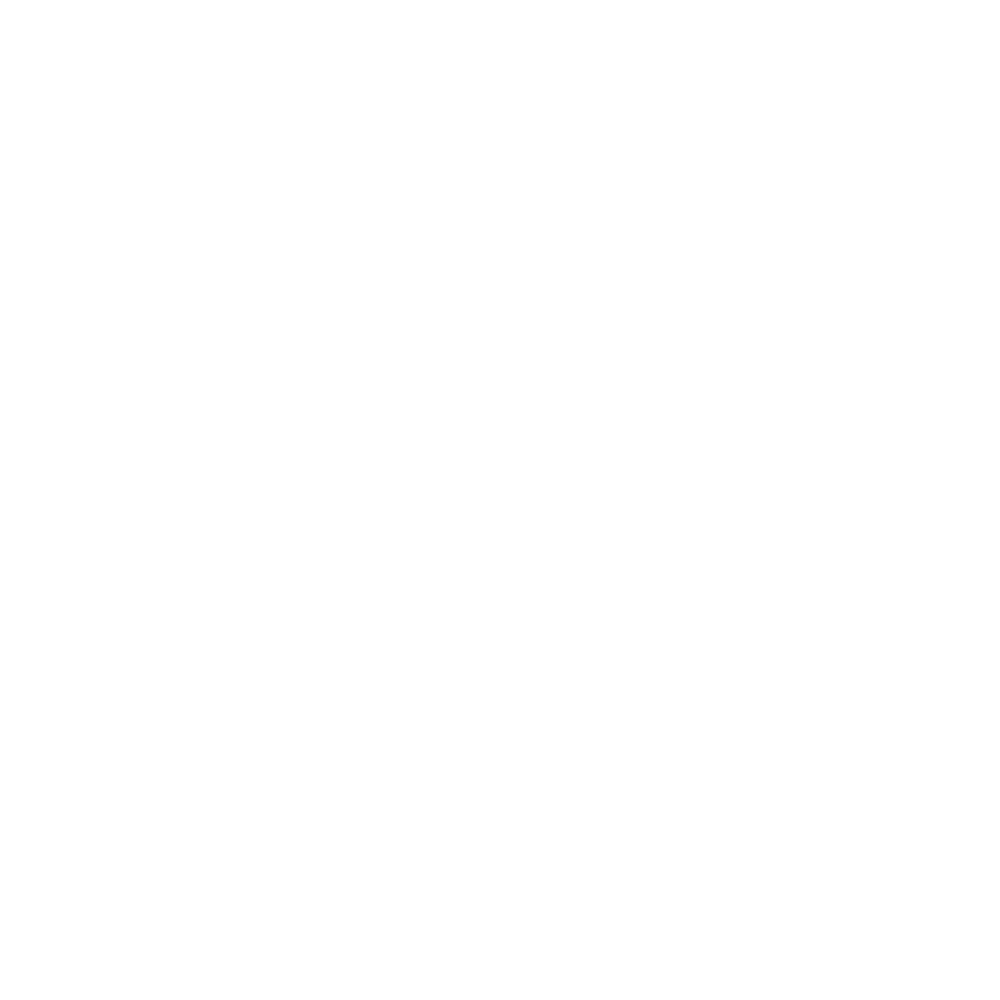

In [6]:
%matplotlib notebook
xs = np.log2(df_lim[['block_size']].values.tolist()).flatten()
ys = np.log2(df_lim[['associativity']].values.tolist()).flatten()
zs = np.array(df_lim[['hit_rate']].values.tolist()).flatten()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs,ys,zs, color='gray')
ax.plot_trisurf(xs, ys, zs, linewidth=0.2, antialiased=True, alpha=0.85, cmap=cm.jet)
ax.set_xlabel('Block Size')
ax.set_ylabel('Associativity')
ax.set_zlabel('Hit Rate')
ax.set_title('Number of Lines & Associativity\nfor a LRU Replacement Cache\n(All Axes are $\log_2$)')
plt.show()

In [75]:
df_lim = df_lru.loc[df_lru['block_size'] == 2**5]
df_lim

,cache_size,block_size,associativity,lru_fifo,num_lines,hits,misses,replacements,hit_rate,num_requests,fifo0_lru1
19,32,32,1,lru,1,201094,314589,314588,0.389957,515683,1
32,64,32,1,lru,2,169317,346366,346364,0.328335,515683,1
33,64,32,2,lru,2,256683,259000,258998,0.497753,515683,1
50,128,32,1,lru,4,95967,419716,419712,0.186097,515683,1
51,128,32,2,lru,4,225267,290416,290412,0.436832,515683,1
...,...,...,...,...,...,...,...,...,...,...,...
1017,524288,32,1024,lru,16384,482021,33662,24262,0.934723,515683,1
1018,524288,32,2048,lru,16384,483420,32263,15879,0.937436,515683,1
1019,524288,32,4096,lru,16384,494595,21088,4704,0.959107,515683,1
1020,524288,32,8192,lru,16384,504472,11211,0,0.978260,515683,1


In [76]:
#Matplotlib 3d cannot currently plot log scale, so you have to do it manually.
#https://stackoverflow.com/questions/3909794/plotting-mplot3d-axes3d-xyz-surface-plot-with-log-scale
import matplotlib.ticker as mticker

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$2^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

<IPython.core.display.Javascript object>


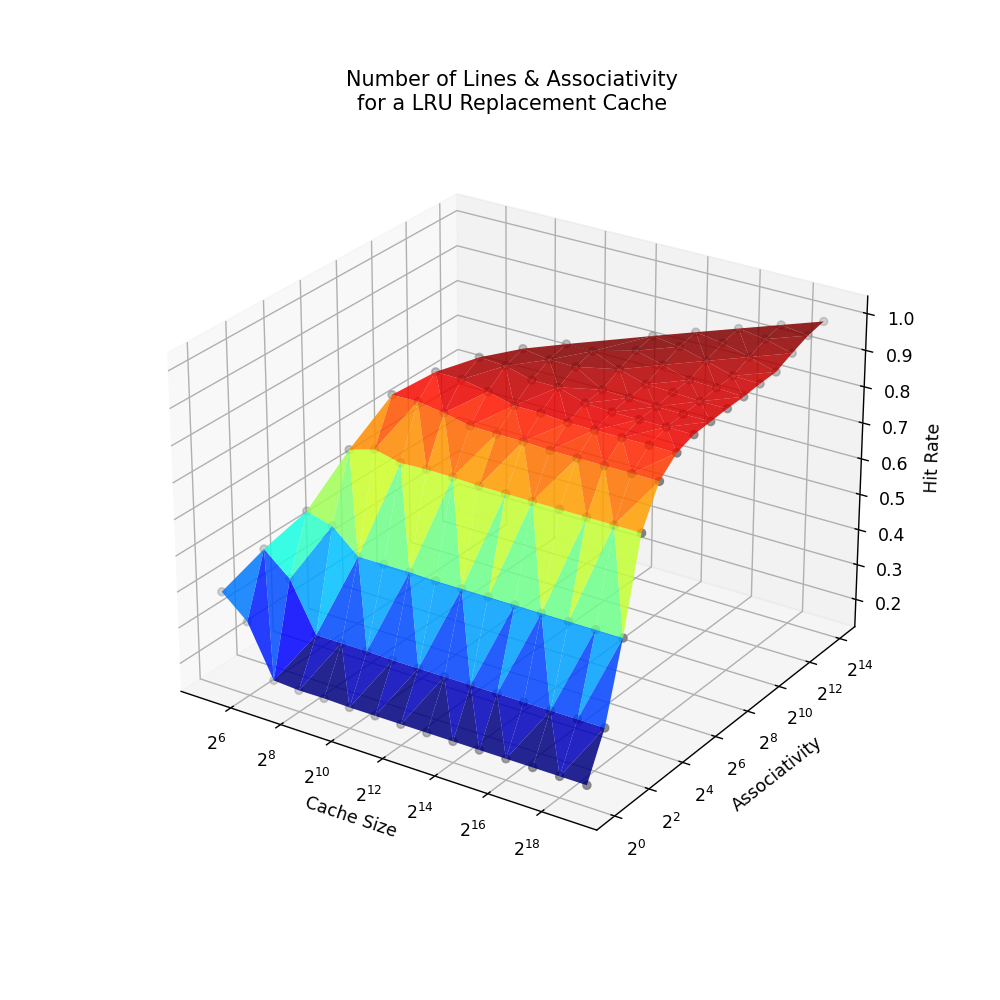

In [77]:
%matplotlib notebook
xs = np.log2(df_lim[['cache_size']].values.tolist()).flatten()
ys = np.log2(df_lim[['associativity']].values.tolist()).flatten()
zs = np.array(df_lim[['hit_rate']].values.tolist()).flatten()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs,ys,zs, color='gray')

ax.plot_trisurf(xs, ys, zs, linewidth=0.2, antialiased=True, alpha=0.85, cmap=cm.jet)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_xlabel('Cache Size')
ax.set_ylabel('Associativity')
ax.set_zlabel('Hit Rate')
ax.set_title('Number of Lines & Associativity\nfor a LRU Replacement Cache')
plt.show()

<IPython.core.display.Javascript object>


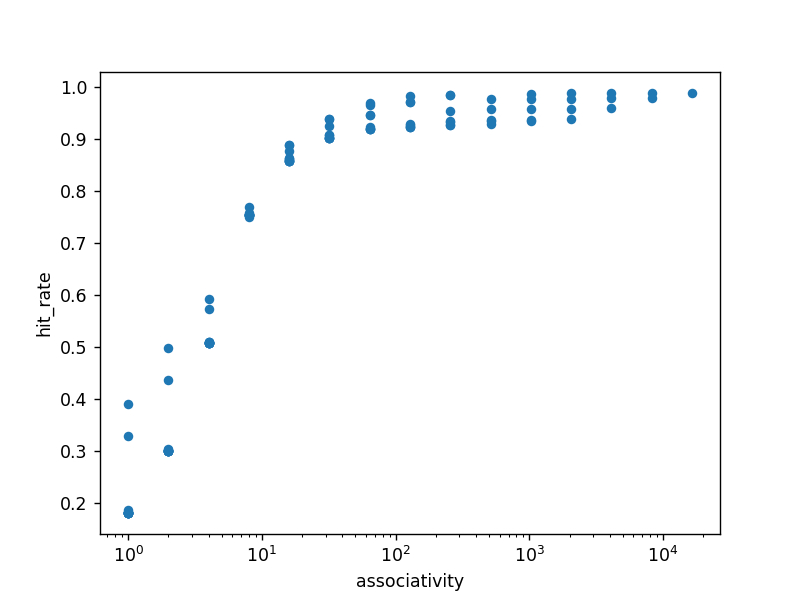

<AxesSubplot:xlabel='associativity', ylabel='hit_rate'>

In [9]:
df_lim.plot(x='associativity', y='hit_rate', kind='scatter', logx=True)